In [1]:
import netCDF4
import xarray as xr

# canopy height data: from NetCDF to Zarr

The canopy height dataset is provided as chunked NetCDF4/HDF5 data. It was reprojected and downloaded from GEE, and reprojected with ERA5Land in crib. It is only for Europe, need to download other area from GEE.

## Input variables

In [2]:
year = 2015

In [3]:
ROOT_DIR = '/gpfs/work2/0/ttse0619'
hc_PATH = (
    f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
    f'1input_data/{year}global/canopy_height/canopy_height_11kmEurope20230921_10km.nc'
)
OUT_PATH = (
    f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
    f'1input_data/{year}global/canopy_height/hc.zarr'
)

In [4]:
ERA5_PATH = (
    f'{ROOT_DIR}/francesco/Projects/EcoExtreML/Data/'
    f'1input_data/{year}global/era5land/era5land.zarr'
)

## Converting the dataset

Find out chunking strategy of the dataset:

In [5]:
def get_chunking(nc_path):
    with netCDF4.Dataset(nc_path) as nc:
        chunks = {
            name: dict(zip(var.dimensions, var.chunking()))
            for name, var in nc.variables.items()
        }
    return chunks

In [6]:
chunks = get_chunking(hc_PATH)
chunks # no chunks in hc file

{'x': {'x': 'c'},
 'y': {'y': 'c'},
 'band': {'band': 'c'},
 'spatial_ref': {},
 '__xarray_dataarray_variable__': {'band': 'c', 'y': 'o', 'x': 'n'}}

We now open the landcover NetCDF files using the same chunking scheme as in the NetCDF file:

In [14]:
hc = xr.open_dataset(hc_PATH)
hc = hc.squeeze('band')  # drop band dimension

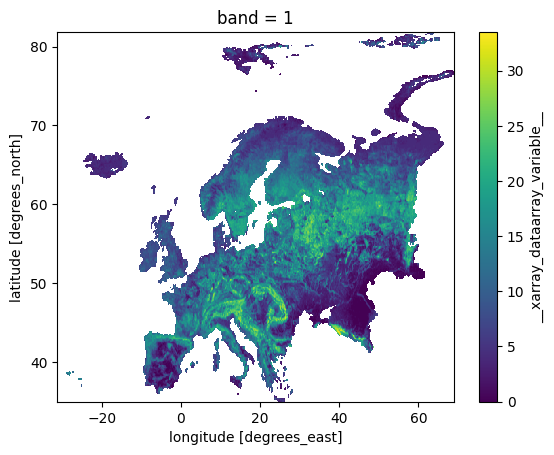

In [15]:
hc.__xarray_dataarray_variable__.plot()

In [16]:
# fix naming of coordinates
hc = hc.rename(
    x='longitude',
    y='latitude'
)

# (-180;180) -> (0;360)
hc = hc.assign_coords(
    longitude=(hc.longitude + 360) % 360,
    latitude=hc.latitude
)

# roll array to reorder coordinates 
nroll = (hc.longitude.values > 180 ).sum()
hc = hc.roll(longitude=-nroll, roll_coords=True)

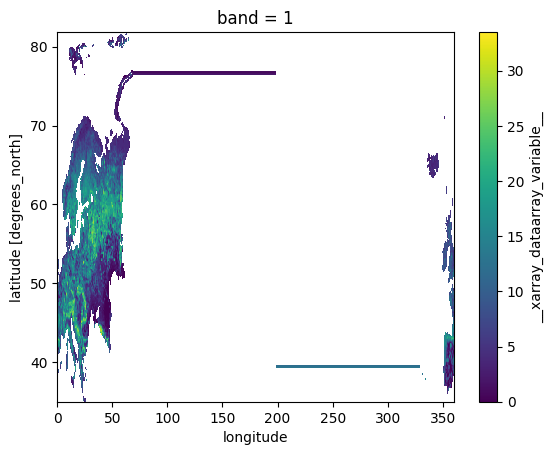

In [17]:
hc.__xarray_dataarray_variable__.plot()

In [23]:
hc.hc.mean().compute()

<xarray.DataArray 'hc' ()>
array(10.361472, dtype=float32)
Coordinates:
    band     int64 1

In [18]:
hc = hc.rename({"__xarray_dataarray_variable__":'hc'})

In [20]:
hc = hc.chunk(
    longitude=250, 
    latitude=250
)
hc.to_zarr(OUT_PATH, mode='w')

In [21]:
xr.open_zarr(OUT_PATH).hc.mean().compute()

<xarray.DataArray 'hc' ()>
array(10.361472, dtype=float32)
Coordinates:
    band     int64 1